# Effects of different priors on attack performance

This notebook corresponds to the experiments gray box attacks of Section 6.1.3 of supplementary material

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torch
from torch.distributions import Gamma, MultivariateNormal
from torch.distributions.kl import kl_divergence

import numpyro
from numpyro.infer.autoguide import AutoDelta
from numpyro.infer import SVI, Trace_ELBO

import jax.numpy as jnp
from jax.random import PRNGKey

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from tqdm import tqdm

from src.weights_optimizer import WeightsOptimizer
from src.horseshoe_lin_reg import HorseshoeLinearRegression
from src.utils import remove_zeros, to_tensor, nig_kl_div, to_np
from src.bayes_lin_reg import NIGLinearRegression

from src.boston_visualization_functions import plot_samples_kde_single_param, plot_samples_kde, plot_intervals_NIG

/home/mcarreau/miniconda3/envs/poisoning_bayesian_inference/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setup

In [3]:
boston = fetch_openml(name="boston", version=1, as_frame=False)
X = boston.data.astype(np.float32)
y = boston.target.astype(np.float32)
n_features = X.shape[1]
feature_names = boston.feature_names

In [4]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train_raw.copy()
X_test = X_test_raw.copy()

idx_to_scale = np.ones(len(boston.feature_names), dtype=bool)
idx_to_scale[boston.feature_names.index("CHAS")] = False

scaler = StandardScaler()
X_train[:, idx_to_scale] = scaler.fit_transform(X_train_raw[:, idx_to_scale])
X_train = np.concatenate((np.ones((X_train.shape[0], 1), dtype=np.float32), X_train), axis=1)

X_test[:, idx_to_scale] = scaler.fit_transform(X_test_raw[:, idx_to_scale])
X_test = np.concatenate((np.ones((X_test.shape[0], 1), dtype=np.float32), X_test), axis=1)

In [5]:
data_NIG = {"X": torch.tensor(X_train), "y":torch.tensor(y_train)}
data_HS = {"X": torch.tensor(X_train[:, 1:]), "y":torch.tensor(y_train)}

n_points = X_train.shape[0]

## Perform attacks with different priors

In [6]:
# Attack parameters

target_feature = "RM"
target_id = boston.feature_names.index(target_feature)
target_mean_val = 0 


max_occurence = 2 
max_L1 = 30
n_repeats = 5
heuristic = "2O-ISCD"

attack_params = {"heuristic": "2O-ISCD",
               "n_MC_samples_adv": 1000,
               "n_MC_samples_post": 100,
               "max_iterations": max_L1 + 5,
               "stopping_ratio": None,
               "betas": None,
               "eps": None,
               "lr": None
                }



### Horseshoe prior

In [ ]:
torch.manual_seed(0)
model_HS = HorseshoeLinearRegression()

model_HS.seed = 0

samples_HS = model_HS.sample_posterior(5000, data_HS, warmup_steps=500)

beta_adv = samples_HS["beta"].mean(0)
beta_adv[target_id] = target_mean_val

sigma_adv = (samples_HS['sigma']).mean()
intercept_adv = (samples_HS['intercept']).mean()

y_adv = torch.tensor(X_train[:, 1:]) @ beta_adv + intercept_adv + torch.randn(*y_train.shape) * sigma_adv

data_adv = {"X": torch.tensor(X_train[:, 1:]), "y": y_adv}

sample_adv_HS = lambda n: model_HS.sample_posterior(n, data_adv, warmup_steps=100)

opti_HS = WeightsOptimizer(data_HS, model_HS, sample_adv_HS)

model_HS.seed = 0
weights_HS = torch.zeros((n_repeats, n_points), dtype=torch.int64)
for i in tqdm(range(n_repeats)):
    weights = opti_HS.optimize(max_occurence=max_occurence, max_L1=max_L1,
                        heuristic=attack_params["heuristic"],
                        max_iterations=attack_params["max_iterations"], 
                        n_MC_samples_adv=attack_params["n_MC_samples_adv"], 
                        n_MC_samples_post=attack_params["n_MC_samples_post"])
    weights_HS[i] = weights
    

 40%|████      | 2/5 [02:41<04:02, 80.89s/it]

inf params at iteration 9
inf params at iteration 14


100%|██████████| 5/5 [07:02<00:00, 84.56s/it]


In [ ]:
# Save the resulting weights
save_path_HS = None #"../output/gray_box/weights_HS_array"
if save_path_HS is not None:
    torch.save(weights_HS, save_path_HS)

In [ ]:
# Load the resulting weights if required

load_path_HS = "../output/gray_box/weights_HS_array"

if load_path_HS is not None:
        
    torch.manual_seed(0)
    model_HS = HorseshoeLinearRegression()

    model_HS.seed = 0

    samples_HS = model_HS.sample_posterior(5000, data_HS, warmup_steps=500)

    beta_adv = samples_HS["beta"].mean(0)
    beta_adv[target_id] = target_mean_val

    sigma_adv = (samples_HS['sigma']).mean()
    intercept_adv = (samples_HS['intercept']).mean()

    y_adv = torch.tensor(X_train[:, 1:]) @ beta_adv + intercept_adv + torch.randn(*y_train.shape) * sigma_adv

    data_adv = {"X": torch.tensor(X_train[:, 1:]), "y": y_adv}

    sample_adv_HS = lambda n: model_HS.sample_posterior(n, data_adv, warmup_steps=100)

    weights_HS = torch.load(load_path_HS)

/tmp/ipykernel_322220/191783872.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights_HS = torch.load(load_path_HS)


### NIG non informative prior

In [78]:
# Prior
mu0 = torch.zeros(n_features + 1, dtype=torch.float32)  # Prior mean vector for beta, including intercept
v0 = torch.eye(n_features + 1, dtype=torch.float32) * 100  # Prior covariance matrix for beta, including intercept

a0 = 2.0  # Shape parameter for the inverse gamma prior 
b0 = 2.0 # Rate parameter for the inverse gamma prior

# Adversarial
model_NIG = NIGLinearRegression(mu0, v0, a0, b0)
muA, vA, aA, bA = model_NIG.posterior_parameters(data_NIG)
muA[target_id + 1] = target_mean_val

tauA = aA / bA
tau_adv_dist = Gamma(aA, bA)
beta_adv_dist = MultivariateNormal(muA, vA / tauA)

def sample_adv_NIG(n_samples):
    """
    Samples from the adversarial target

    Parameters:
    - n_samples: shape of the output tensor
    """
    
    # Sample the posterior
    sigma2_sample = 1.0 / ( tau_adv_dist.sample(torch.tensor([n_samples])) )
    centered_beta_dist = MultivariateNormal(torch.zeros_like(muA), vA)
    beta_sample = centered_beta_dist.sample((n_samples, ))

    beta_sample = muA + (torch.sqrt(sigma2_sample) * 
                         beta_sample.T).T

    return {'beta': beta_sample, 'sigma2': sigma2_sample}


### NIG informative prior

In [79]:
mu0_inf = mu0.clone()
v0_inf = v0.clone()

mu0_inf[target_id+1] = 10.0
v0_inf[target_id+1][target_id+1] = 1e-2

model_NIG_inf = NIGLinearRegression(mu0_inf, v0_inf, a0, b0)
muA_inf, vA_inf, aA_inf, bA_inf = model_NIG_inf.posterior_parameters(data_NIG)
muA_inf[target_id + 1] = target_mean_val

tauA_inf = aA_inf / bA_inf
tau_adv_dist_inf = Gamma(aA_inf, bA_inf)
beta_adv_dist_inf = MultivariateNormal(muA_inf, vA_inf / tauA_inf)

def sample_adv_NIG_inf(n_samples):
    """
    Samples from the adversarial target

    Parameters:
    - n_samples: shape of the output tensor
    """
    
    # Sample the posterior
    sigma2_sample = 1.0 / ( tau_adv_dist_inf.sample(torch.tensor([n_samples])) )
    centered_beta_dist = MultivariateNormal(torch.zeros_like(muA_inf), vA_inf)
    beta_sample = centered_beta_dist.sample((n_samples, ))

    beta_sample = muA_inf + (torch.sqrt(sigma2_sample) * 
                         beta_sample.T).T

    return {'beta': beta_sample, 'sigma2': sigma2_sample}

In [80]:
torch.manual_seed(0)

beta_samples = model_NIG.sample_posterior(5000, data_NIG)["beta"].data.numpy()
beta_samples_target = sample_adv_NIG(5000)["beta"].data.numpy()
beta_samples_inf = model_NIG_inf.sample_posterior(5000, data_NIG)["beta"].data.numpy()
beta_samples_target_inf = sample_adv_NIG_inf(5000)["beta"].data.numpy()

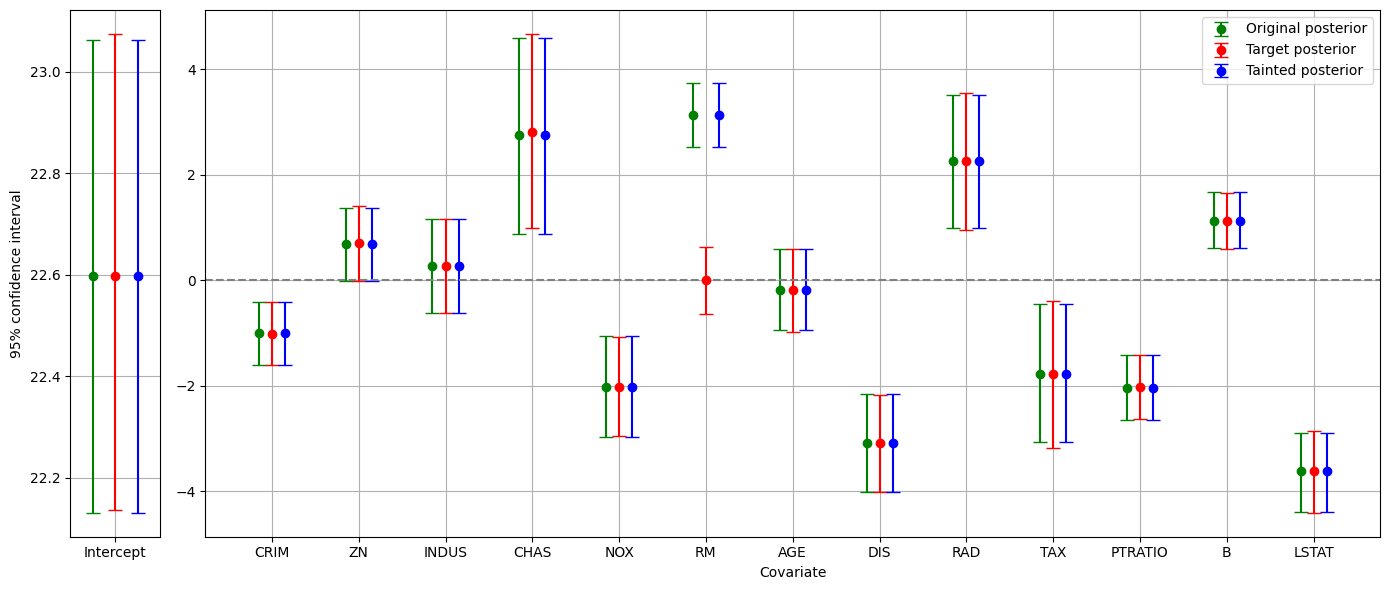

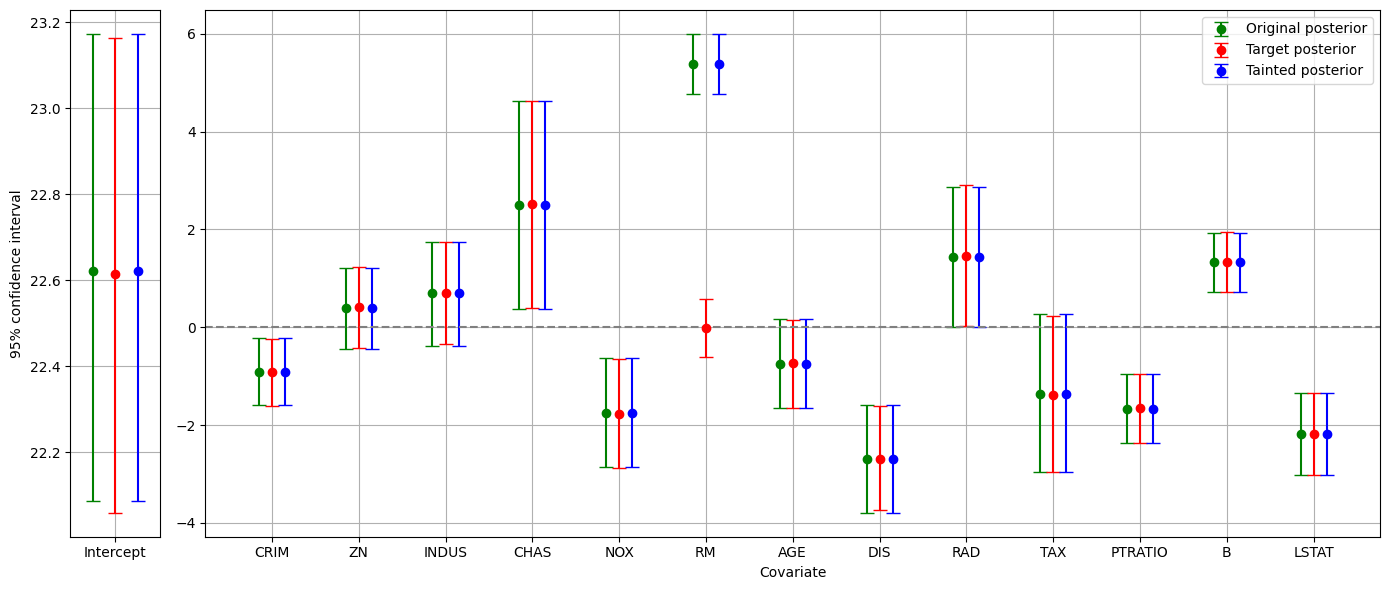

In [81]:
plot_intervals_NIG(beta_samples, beta_samples_target, beta_samples, ylim=None, title="")
plot_intervals_NIG(beta_samples_inf, beta_samples_target_inf, beta_samples_inf, ylim=None, title="")

In [82]:
torch.manual_seed(0)

save_path_NIG = "../output/gray_box/weights_NIG_array"
save_path_NIG_inf = "../output/gray_box/weights_NIG_inf_array"

opti_NIG = WeightsOptimizer(data_NIG, model_NIG, sample_adv_NIG)
weights_NIG = torch.zeros((n_repeats, n_points), dtype=torch.int64)
print("Attacks with non informative NIG")
for i in tqdm(range(n_repeats)):
    weights = opti_NIG.optimize(max_occurence=max_occurence, max_L1=max_L1,
                        heuristic=attack_params["heuristic"],
                        max_iterations=attack_params["max_iterations"], 
                        n_MC_samples_adv=attack_params["n_MC_samples_adv"], 
                        n_MC_samples_post=attack_params["n_MC_samples_post"])
    weights_NIG[i] = weights
    
if save_path_NIG is not None:
    torch.save(weights_NIG, save_path_NIG)

opti_NIG_inf = WeightsOptimizer(data_NIG, model_NIG_inf, sample_adv_NIG_inf)
weights_NIG_inf = torch.zeros((n_repeats, n_points), dtype=torch.int64)
print("Attacks with informative NIG")
for i in tqdm(range(n_repeats)):
    weights = opti_NIG_inf.optimize(max_occurence=max_occurence, max_L1=max_L1,
                        heuristic=attack_params["heuristic"],
                        max_iterations=attack_params["max_iterations"], 
                        n_MC_samples_adv=attack_params["n_MC_samples_adv"], 
                        n_MC_samples_post=attack_params["n_MC_samples_post"])
    weights_NIG_inf[i] = weights
    
if save_path_NIG_inf is not None:
    torch.save(weights_NIG_inf, save_path_NIG_inf)

Attacks with non informative NIG


100%|██████████| 5/5 [00:00<00:00,  6.13it/s]


Attacks with informative NIG


100%|██████████| 5/5 [00:00<00:00,  5.97it/s]


## Evaluate the attacks in gray box settings

### Evaluate effectiveness with non informative NIG prior

In [85]:
weights_lists = [weights_HS, weights_NIG, weights_NIG_inf]
prior_names = ["HS", "NIG", "NIG informative"]

mu_ast, v_ast, a_ast, b_ast = model_NIG.posterior_parameters(data_NIG) 
mean_RM_NIG_orig = float(mu_ast[target_id + 1])
mean_RM_NIG = []
mean_RM_NIG_std = []

tau_post = Gamma(a_ast, b_ast)
beta_post = MultivariateNormal(mu_ast, v_ast / tauA)
KL_NIG_orig = float(nig_kl_div(tau_adv_dist, beta_adv_dist, tau_post, beta_post).detach().numpy())        
KL_NIG = []
KL_NIG_std = []

for lst, name in zip(weights_lists, prior_names):
    print(name)

    mean_RM = []
    KL_div = []

    for w in lst:
    
        mu_ast, v_ast, a_ast, b_ast = model_NIG.posterior_parameters(data_NIG, weights=w) 
        tau_post = Gamma(a_ast, b_ast)
        beta_post = MultivariateNormal(mu_ast, v_ast / tauA)

        KL_div.append(float(nig_kl_div(tau_adv_dist, beta_adv_dist, tau_post, beta_post).detach().numpy()))
        mean_RM.append(mu_ast[target_id + 1])
    
    mean_RM = np.array(mean_RM)
    KL_div = np.array(KL_div)
    mean_RM_NIG.append(mean_RM.mean())
    mean_RM_NIG_std.append(mean_RM.std())
    KL_NIG.append(KL_div.mean())
    KL_NIG_std.append(KL_div.std())
    
    print("Mean RM:", mean_RM.mean(), mean_RM.std())
    print("Objective function:", KL_div.mean(), KL_div.std())
    print()
        

HS
Mean RM: 0.7528991 0.06511891
Objective function: 16.823003387451173 0.6299776482465363

NIG
Mean RM: 0.6076244 0.057600565
Objective function: 15.65639877319336 0.18244827177993603

NIG informative
Mean RM: 0.2554844 0.0
Objective function: 23.95220375061035 0.0



### Evaluate effectiveness with informative NIG prior

In [86]:
weights_lists = [weights_HS, weights_NIG, weights_NIG_inf]
prior_names = ["HS", "NIG", "NIG informative"]

mu_ast, v_ast, a_ast, b_ast = model_NIG_inf.posterior_parameters(data_NIG) 
mean_RM_NIG_inf_orig = float(mu_ast[target_id + 1])
mean_RM_NIG_inf = []
mean_RM_NIG_inf_std = []

tau_post = Gamma(a_ast, b_ast)
beta_post = MultivariateNormal(mu_ast, v_ast / tauA)

KL_NIG_inf_orig = float(nig_kl_div(tau_adv_dist_inf, beta_adv_dist_inf, tau_post, beta_post).detach().numpy())        

KL_NIG_inf = []
KL_NIG_inf_std = []

for lst, name in zip(weights_lists, prior_names):
    print(name)

    mean_RM = []
    KL_div = []

    for w in lst:
    
        mu_ast, v_ast, a_ast, b_ast = model_NIG_inf.posterior_parameters(data_NIG, weights=w) 
        tau_post = Gamma(a_ast, b_ast)
        beta_post = MultivariateNormal(mu_ast, v_ast / tauA)

        KL_div.append(float(nig_kl_div(tau_adv_dist_inf, beta_adv_dist_inf, tau_post, beta_post).detach().numpy()))
        mean_RM.append(mu_ast[target_id + 1])
    
    mean_RM = np.array(mean_RM)
    KL_div = np.array(KL_div)
    
    mean_RM = np.array(mean_RM)
    KL_div = np.array(KL_div)
    mean_RM_NIG_inf.append(mean_RM.mean())
    mean_RM_NIG_inf_std.append(mean_RM.std())
    KL_NIG_inf.append(KL_div.mean())
    KL_NIG_inf_std.append(KL_div.std())

    print("Mean RM:", mean_RM.mean(), mean_RM.std())
    print("Objective function:", KL_div.mean(), KL_div.std())
    print()
        

HS
Mean RM: 4.1803765 0.050669067
Objective function: 176.05517578125 1.5105042441268564

NIG
Mean RM: 4.062746 0.0808906
Objective function: 172.64710083007813 1.3985674770584877

NIG informative
Mean RM: 3.819406 2.3841858e-07
Objective function: 159.2130126953125 0.0



### Evaluate effectiveness with informative Horseshoe prior

In [87]:

BETA_IDX = np.arange(14, 27)
GLOB_SHRINK_IDX = 13
INTERCEPT_IDX = 27
LOC_SHRINK_IDX = np.arange(13)
SIGMA_IDX = 28
BETA_WITH_INTERCEPT_IDX = np.concatenate((BETA_IDX, [INTERCEPT_IDX]))

  0%|          | 0/50000 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [00:12<00:00, 3862.21it/s, init loss: 4378418.5000, avg. loss [47501-50000]: 1227.8582]


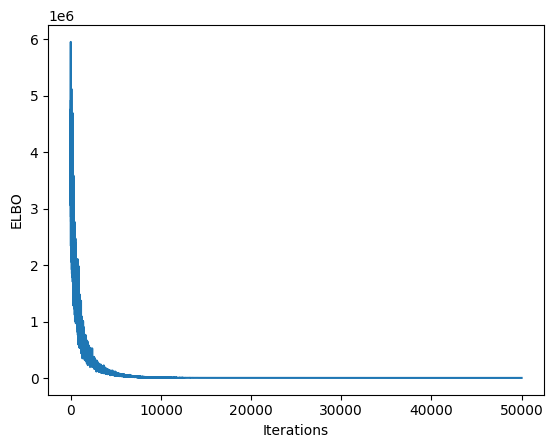

Adv intercept estimate: 22.917303 +- 0.24508509
Adv beta_RM estimate: 0.013388535 +- 0.21903993


100%|██████████| 10000/10000 [00:03<00:00, 2923.37it/s, init loss: 1325.6202, avg. loss [9501-10000]: 1241.9374]


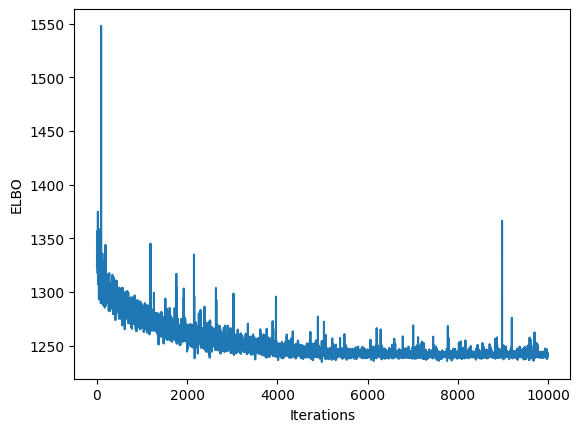

Post intercept estimate: 22.652216 +- 0.2477763
Post beta_RM estimate: 3.1699805 +- 0.32321602
HS


100%|██████████| 5/5 [00:34<00:00,  6.92s/it]


Mean RM: 0.73891544 0.074278526
Objective function: 22.157193756103517 0.8729078705105908

NIG


100%|██████████| 5/5 [00:33<00:00,  6.65s/it]


Mean RM: 0.5749514 0.05942547
Objective function: 23.274651718139648 1.1426779243707905

NIG informative


100%|██████████| 5/5 [00:33<00:00,  6.78s/it]

Mean RM: 0.2493319 0.008112646
Objective function: 37.23189849853516 0.6816975323127464



In [88]:
model_HS.seed = 0
torch.manual_seed(0)

# Compute the VI approx of adversarial target
mean, cov = model_HS.normal_posterior_approximation(data_adv, method="VI", optim_steps=50000, lr=1e-3, verbose=True, diagonal=False, warm_start_svi=True,) 
adv_normal_approx_HS = MultivariateNormal(mean, cov) 
print("Adv intercept estimate:", to_np(mean[INTERCEPT_IDX]), "+-", to_np(torch.sqrt(cov[INTERCEPT_IDX, INTERCEPT_IDX])))
print("Adv beta_RM estimate:", to_np(mean[BETA_IDX[target_id]]), "+-", to_np(torch.sqrt(cov[BETA_IDX[target_id], BETA_IDX[target_id]])))

# Warmup for the VI approx of posterior distribution
mean, cov = model_HS.normal_posterior_approximation(data_HS, method="VI", optim_steps=10000, lr=1e-3, verbose=True, warm_start_svi=True, diagonal=False) 
print("Post intercept estimate:", to_np(mean[INTERCEPT_IDX]), "+-", to_np(torch.sqrt(cov[INTERCEPT_IDX, INTERCEPT_IDX])))
print("Post beta_RM estimate:", to_np(mean[BETA_IDX[target_id]]), "+-", to_np(torch.sqrt(cov[BETA_IDX[target_id], BETA_IDX[target_id]])))

weights_lists = [weights_HS, weights_NIG, weights_NIG_inf]
prior_names = ["HS", "NIG", "NIG informative"]

beta_samples = model_HS.sample_posterior(2000, data_HS, warmup_steps=500)["beta"]

mean_RM_HS_orig = float(beta_samples[:, target_id].mean())
mean_RM_HS = []
mean_RM_HS_std = []
KL_HS_orig = float(kl_divergence(adv_normal_approx_HS, MultivariateNormal(mean, cov)))
KL_HS = []
KL_HS_std = []


for lst, name in zip(weights_lists, prior_names):
    print(name)

    mean_RM = []
    KL_div = []

    for w in tqdm(lst):
        mean, cov = model_HS.normal_posterior_approximation(data_HS, weights=w, method="VI", optim_steps=10000, lr=1e-3, warm_start_svi=True, diagonal=False) 
        post_normal_approx_HS = MultivariateNormal(mean, cov) 
        
        KL_div.append(float(kl_divergence(adv_normal_approx_HS, post_normal_approx_HS).detach().numpy()))

        # mean RM from MCMC samples
        beta_samples = model_HS.sample_posterior(2000, data_HS, weights=w, warmup_steps=500)["beta"]
        mean_RM.append(beta_samples[:, target_id].mean())
    
    mean_RM = np.array(mean_RM)
    KL_div = np.array(KL_div)
    
    mean_RM_HS.append(mean_RM.mean())
    mean_RM_HS_std.append(mean_RM.std())
    KL_HS.append(KL_div.mean())
    KL_HS_std.append(KL_div.std())

    print("Mean RM:", mean_RM.mean(), mean_RM.std())
    print("Objective function:", KL_div.mean(), KL_div.std())
    print()
        
            


### Generate Markdown code for one experiment

In [ ]:
txt_path = "../output/gray_box/tables.txt"

prior_names = ['Horseshoe', 'NIG', 'NIG informative']

textfile = open(txt_path, "w")
textfile.write("**KL Divergence**\n\n")
textfile.write("| | Horseshoe   |   NIG      |  NIG informative  |\n")
textfile.write("|----|:----------:|:-------------:|:------:|\n")
textfile.write("| **No attack** | {:.2f} | {:.2f} | {:.2f} |\n".format(KL_HS_orig, KL_NIG_orig, KL_NIG_inf_orig))
for i in range(3):

    textfile.write("| **{}** | {:.2f} $\\pm$ {:.2f} | {:.2f} $\\pm$ {:.2f} | {:.2f} $\\pm$ {:.2f} |\n".format(prior_names[i], KL_HS[i], KL_HS_std[i], KL_NIG[i], KL_NIG_std[i], KL_NIG_inf[i], KL_NIG_inf_std[i]))


textfile.write("\n\n**Mean RM value**\n\n")
textfile.write("| | Horseshoe   |   NIG      |  NIG informative  |\n")
textfile.write("|----|:----------:|:-------------:|:------:|\n")
textfile.write("| **No attack** | {:.2f} | {:.2f} | {:.2f} |\n".format(mean_RM_HS_orig, mean_RM_NIG_orig, mean_RM_NIG_inf_orig))
for i in range(3):

    textfile.write("| **{}** | {:.2f} $\\pm$ {:.2f} | {:.2f} $\\pm$ {:.2f} | {:.2f} $\\pm$ {:.2f} |\n".format(prior_names[i], mean_RM_HS[i], mean_RM_HS_std[i], mean_RM_NIG[i], mean_RM_NIG_std[i], mean_RM_NIG_inf[i], mean_RM_NIG_inf_std[i]))


textfile.close()

# Summary of results with different prior parameters 
Varying $\mathbb{E}_{\pi_0}[\beta_{RM}]$ and $\mathbb{V}_{\pi_0}[\beta_{RM}]$ and reporting the objective KL divergence and the mean RM values


### $\mathbb{E}_{\pi_0}[\beta_{RM}] = 10.0 ; \mathbb{V}_{\pi_0}[\beta_{RM}] = 0.1 $


**KL Divergence**

| | Horseshoe   |   NIG      |  NIG informative  |
|----|:----------:|:-------------:|:------:|
| **No attack** | 95.95 | 93.15 | 115.57 |
| **Horseshoe** | 22.09 $\pm$ 0.87 | 16.82 $\pm$ 0.63 | 25.15 $\pm$ 0.44 |
| **NIG** | 23.17 $\pm$ 1.15 | 15.66 $\pm$ 0.18 | 23.68 $\pm$ 0.43 |
| **NIG informative** | 25.63 $\pm$ 1.12 | 16.39 $\pm$ 0.45 | 23.27 $\pm$ 0.19 |


**Mean RM value**

| | Horseshoe   |   NIG      |  NIG informative  |
|----|:----------:|:-------------:|:------:|
| **No attack** | 3.21 | 3.15 | 3.46 |
| **Horseshoe** | 0.74 $\pm$ 0.07 | 0.75 $\pm$ 0.07 | 1.27 $\pm$ 0.06 |
| **NIG** | 0.57 $\pm$ 0.06 | 0.61 $\pm$ 0.06 | 1.12 $\pm$ 0.05 |
| **NIG informative** | 0.43 $\pm$ 0.03 | 0.46 $\pm$ 0.03 | 0.98 $\pm$ 0.02 |



### $\mathbb{E}_{\pi_0}[\beta_{RM}] = 3.0 ; \mathbb{V}_{\pi_0}[\beta_{RM}] = 0.1 $

**KL Divergence**

| | Horseshoe   |   NIG      |  NIG informative  |
|----|:----------:|:-------------:|:------:|
| **No attack** | 96.05 | 93.15 | 95.06 |
| **Horseshoe** | 22.16 $\pm$ 0.87 | 16.82 $\pm$ 0.63 | 17.63 $\pm$ 0.64 |
| **NIG** | 23.27 $\pm$ 1.14 | 15.66 $\pm$ 0.18 | 16.32 $\pm$ 0.22 |
| **NIG informative** | 24.03 $\pm$ 0.80 | 15.59 $\pm$ 0.29 | 16.16 $\pm$ 0.26 |


**Mean RM value**

| | Horseshoe   |   NIG      |  NIG informative  |
|----|:----------:|:-------------:|:------:|
| **No attack** | 3.21 | 3.15 | 3.14 |
| **Horseshoe** | 0.74 $\pm$ 0.07 | 0.75 $\pm$ 0.07 | 0.88 $\pm$ 0.06 |
| **NIG** | 0.57 $\pm$ 0.06 | 0.61 $\pm$ 0.06 | 0.74 $\pm$ 0.05 |
| **NIG informative** | 0.51 $\pm$ 0.03 | 0.54 $\pm$ 0.03 | 0.67 $\pm$ 0.03 |




### $\mathbb{E}_{\pi_0}[\beta_{RM}] = 0.0 ; \mathbb{V}_{\pi_0}[\beta_{RM}] = 0.1 $

**KL Divergence**

| | Horseshoe   |   NIG      |  NIG informative  |
|----|:----------:|:-------------:|:------:|
| **No attack** | 96.05 | 93.15 | 86.89 |
| **Horseshoe** | 22.16 $\pm$ 0.87 | 16.82 $\pm$ 0.63 | 15.12 $\pm$ 0.71 |
| **NIG** | 23.27 $\pm$ 1.14 | 15.66 $\pm$ 0.18 | 13.91 $\pm$ 0.19 |
| **NIG informative** | 23.66 $\pm$ 0.52 | 15.43 $\pm$ 0.21 | 13.64 $\pm$ 0.20 |


**Mean RM value**

| | Horseshoe   |   NIG      |  NIG informative  |
|----|:----------:|:-------------:|:------:|
| **No attack** | 3.21 | 3.15 | 3.00 |
| **Horseshoe** | 0.74 $\pm$ 0.07 | 0.75 $\pm$ 0.07 | 0.71 $\pm$ 0.06 |
| **NIG** | 0.57 $\pm$ 0.06 | 0.61 $\pm$ 0.06 | 0.57 $\pm$ 0.05 |
| **NIG informative** | 0.57 $\pm$ 0.07 | 0.60 $\pm$ 0.06 | 0.57 $\pm$ 0.06 |



### $\mathbb{E}_{\pi_0}[\beta_{RM}] = 10.0 ; \mathbb{V}_{\pi_0}[\beta_{RM}] = 0.01 $

**KL Divergence**

| | Horseshoe   |   NIG      |  NIG informative  |
|----|:----------:|:-------------:|:------:|
| **No attack** | 96.05 | 93.15 | 339.76 |
| **Horseshoe** | 22.16 $\pm$ 0.87 | 16.82 $\pm$ 0.63 | 176.06 $\pm$ 1.51 |
| **NIG** | 23.27 $\pm$ 1.14 | 15.66 $\pm$ 0.18 | 172.65 $\pm$ 1.40 |
| **NIG informative** | 37.23 $\pm$ 0.68 | 23.95 $\pm$ 0.00 | 159.21 $\pm$ 0.00 |


**Mean RM value**

| | Horseshoe   |   NIG      |  NIG informative  |
|----|:----------:|:-------------:|:------:|
| **No attack** | 3.21 | 3.15 | 5.38 |
| **Horseshoe** | 0.74 $\pm$ 0.07 | 0.75 $\pm$ 0.07 | 4.18 $\pm$ 0.05 |
| **NIG** | 0.57 $\pm$ 0.06 | 0.61 $\pm$ 0.06 | 4.06 $\pm$ 0.08 |
| **NIG informative** | 0.25 $\pm$ 0.01 | 0.26 $\pm$ 0.00 | 3.82 $\pm$ 0.00 |


### $\mathbb{E}_{\pi_0}[\beta_{RM}] = 3.0 ; \mathbb{V}_{\pi_0}[\beta_{RM}] = 0.01 $

**KL Divergence**

| | Horseshoe   |   NIG      |  NIG informative  |
|----|:----------:|:-------------:|:------:|
| **No attack** | 96.05 | 93.15 | 112.75 |
| **Horseshoe** | 22.16 $\pm$ 0.87 | 16.82 $\pm$ 0.63 | 29.29 $\pm$ 0.71 |
| **NIG** | 23.27 $\pm$ 1.14 | 15.66 $\pm$ 0.18 | 27.15 $\pm$ 0.50 |
| **NIG informative** | 25.01 $\pm$ 0.67 | 16.11 $\pm$ 0.19 | 26.32 $\pm$ 0.03 |


**Mean RM value**

| | Horseshoe   |   NIG      |  NIG informative  |
|----|:----------:|:-------------:|:------:|
| **No attack** | 3.21 | 3.15 | 3.10 |
| **Horseshoe** | 0.74 $\pm$ 0.07 | 0.75 $\pm$ 0.07 | 1.59 $\pm$ 0.04 |
| **NIG** | 0.57 $\pm$ 0.06 | 0.61 $\pm$ 0.06 | 1.49 $\pm$ 0.04 |
| **NIG informative** | 0.43 $\pm$ 0.05 | 0.46 $\pm$ 0.05 | 1.38 $\pm$ 0.03 |


### $\mathbb{E}_{\pi_0}[\beta_{RM}] = 0.0 ; \mathbb{V}_{\pi_0}[\beta_{RM}] = 0.01 $

**KL Divergence**

| | Horseshoe   |   NIG      |  NIG informative  |
|----|:----------:|:-------------:|:------:|
| **No attack** | 96.05 | 93.15 | 52.93 |
| **Horseshoe** | 22.16 $\pm$ 0.87 | 16.82 $\pm$ 0.63 | 9.12 $\pm$ 1.25 |
| **NIG** | 23.27 $\pm$ 1.14 | 15.66 $\pm$ 0.18 | 7.66 $\pm$ 0.53 |
| **NIG informative** | 24.71 $\pm$ 1.17 | 16.91 $\pm$ 0.58 | 5.49 $\pm$ 0.04 |


**Mean RM value**

| | Horseshoe   |   NIG      |  NIG informative  |
|----|:----------:|:-------------:|:------:|
| **No attack** | 3.21 | 3.15 | 2.12 |
| **Horseshoe** | 0.74 $\pm$ 0.07 | 0.75 $\pm$ 0.07 | 0.47 $\pm$ 0.04 |
| **NIG** | 0.57 $\pm$ 0.06 | 0.61 $\pm$ 0.06 | 0.38 $\pm$ 0.04 |
| **NIG informative** | 0.73 $\pm$ 0.03 | 0.74 $\pm$ 0.03 | 0.48 $\pm$ 0.02 |
